In [1]:
import pandas as pd
from numpy import array

from math import sqrt
from datetime import datetime
from matplotlib import pyplot as plt
from numpy import concatenate

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten

In [3]:
def agregarNuevoValor(x_test, nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

In [4]:
def formato_inicial_dataset(dataset_original):
    formato_inicial = dataset_original.drop(["serie_equipo"], axis=1)
    formato_inicial = formato_inicial.set_index("fecha_servicio")
    
    return formato_inicial

In [5]:
def df_original_a_serie(df):
    array_df = df.to_numpy()
    nuevos_valores = []
    
    for i in range(array_df.shape[0]):
#         print(array_df[i])
        valor_b5 = list(array_df[i])
        valor_b5 = int("".join(map(str, valor_b5)))
#         print(valor_b5)
        valor_b10 = int(str(valor_b5), 5)
        nuevos_valores.append(valor_b10)
    
    df["valores"] = nuevos_valores
    
    nuevo_df = df.drop(["uso_intensivo","temp_planta","mtto_planta","picos_electricos","tubo_rayosx","tarjeta_detector","tarjeta_IOB","otras_tarjetas","motor","software","PILZ","shutter","cables","otro","mtto_correctivo"], axis=1)
        
    return nuevo_df

In [6]:
def df_original_a_serie(df):
    array_df = df.to_numpy()
    nuevos_valores = []
    
    for i in range(array_df.shape[0]):
        print(array_df[i])
        valor_b5 = list(array_df[i])
        valor_b5 = int("".join(map(str, valor_b5)))
        print(valor_b5)
        valor_b10 = int(str(valor_b5), 5)
        nuevos_valores.append(valor_b10)
    
    df["valores"] = nuevos_valores
    
    nuevo_df = df.drop(["uso_intensivo","temp_planta","mtto_planta","picos_electricos","tubo_rayosx","tarjeta_detector","tarjeta_IOB","otras_tarjetas","motor","software","PILZ","shutter","cables","otro","mtto_correctivo"], 1)
        
    return nuevo_df

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    from pandas import DataFrame
    from pandas import concat
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
def dec_to_base(num,base):  #Maximum base - 36
    base_num = ""
    while num>0:
        dig = int(num%base)
        if dig<10:
            base_num += str(dig)
        else:
            base_num += chr(ord('A')+dig-10)  #Using uppercase letters
        num //= base
    base_num = base_num[::-1]  #To reverse the string
    return base_num

In [9]:
# Carga el dataset
dataset_E162533 = pd.read_excel("./E162533.xlsx")
dataset_E162533.head()

,fecha_servicio,serie_equipo,tubo_rayosx,tarjeta_detector,tarjeta_IOB,otras_tarjetas,motor,software,PILZ,shutter,cables,otro,uso_intensivo,picos_electricos,temp_planta,mtto_planta,mtto_correctivo
0,2018-07-17,E162533,0,0,0,0,0,0,0,0,0,0,1,1,4,3,0
1,2018-07-18,E162533,0,0,0,0,0,0,0,0,0,0,1,1,4,3,0
2,2018-07-19,E162533,0,0,0,0,0,0,0,0,0,0,1,1,4,3,0
3,2018-07-20,E162533,0,0,0,0,0,0,0,0,0,0,1,1,4,3,0
4,2018-07-21,E162533,0,0,0,0,0,0,0,0,0,0,1,1,4,3,0


In [10]:
E162533_original = dataset_E162533.copy()

In [11]:
dataset_E162533.describe()

,tubo_rayosx,tarjeta_detector,tarjeta_IOB,otras_tarjetas,motor,software,PILZ,shutter,cables,otro,uso_intensivo,picos_electricos,temp_planta,mtto_planta,mtto_correctivo
count,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.0,1416.000000,1416.000000,1416.0,1416.000000
mean,0.014831,0.016243,0.013418,0.012712,0.014124,0.024718,0.016243,0.012712,0.012712,0.012712,1.0,0.434322,3.650424,3.0,0.036017
std,0.120917,0.126453,0.115097,0.112068,0.118045,0.155318,0.126453,0.112068,0.112068,0.112068,0.0,0.495843,0.477005,0.0,0.186398
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,3.000000,3.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,3.000000,3.0,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,4.000000,3.0,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,4.000000,3.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,4.000000,3.0,1.000000


In [12]:
dataset_E162533.dtypes

fecha_servicio      datetime64[ns]
serie_equipo                object
tubo_rayosx                  int64
tarjeta_detector             int64
tarjeta_IOB                  int64
otras_tarjetas               int64
motor                        int64
software                     int64
PILZ                         int64
shutter                      int64
cables                       int64
otro                         int64
uso_intensivo                int64
picos_electricos             int64
temp_planta                  int64
mtto_planta                  int64
mtto_correctivo              int64
dtype: object

In [13]:
dataset_E162533 = formato_inicial_dataset(dataset_E162533)
dataset_E162533

,tubo_rayosx,tarjeta_detector,tarjeta_IOB,otras_tarjetas,motor,software,PILZ,shutter,cables,otro,uso_intensivo,picos_electricos,temp_planta,mtto_planta,mtto_correctivo
fecha_servicio,,,,,,,,,,,,,,,
2018-07-17,0,0,0,0,0,0,0,0,0,0,1,1,4,3,0
2018-07-18,0,0,0,0,0,0,0,0,0,0,1,1,4,3,0
2018-07-19,0,0,0,0,0,0,0,0,0,0,1,1,4,3,0
2018-07-20,0,0,0,0,0,0,0,0,0,0,1,1,4,3,0
2018-07-21,0,0,0,0,0,0,0,0,0,0,1,1,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-28,0,0,0,0,0,0,0,0,0,0,1,0,3,3,0
2022-05-29,0,0,0,0,0,0,0,0,0,0,1,0,3,3,0
2022-05-30,0,0,0,0,0,0,0,0,0,0,1,0,3,3,0


In [14]:
dataset_E162533_serie = df_original_a_serie(dataset_E162533)
dataset_E162533_serie

[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 1 0 0 0 0 1 0 4 3 1]
1000010431
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 

[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 1 4 3 0]
11430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 0 0 0 0 0 0 0 0 0 1 0 4 3 0]
10430
[0 1 1 1 0 0

C:\Users\Jorge\AppData\Local\Temp/ipykernel_15116/1082795941.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  nuevo_df = df.drop(["uso_intensivo","temp_planta","mtto_planta","picos_electricos","tubo_rayosx","tarjeta_detector","tarjeta_IOB","otras_tarjetas","motor","software","PILZ","shutter","cables","otro","mtto_correctivo"], 1)


,valores
fecha_servicio,
2018-07-17,865
2018-07-18,865
2018-07-19,865
2018-07-20,865
2018-07-21,865
...,...
2022-05-28,715
2022-05-29,715
2022-05-30,715


In [15]:
E162533_serie_values = dataset_E162533_serie.values
E162533_serie_values

array([[865],
       [865],
       [865],
       ...,
       [715],
       [840],
       [715]], dtype=int64)

In [16]:
E162533_supervised_df = series_to_supervised(E162533_serie_values, 15, 1)
E162533_supervised_df

,var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
15,8.650000e+02,8.650000e+02,8.650000e+02,8.650000e+02,865.0,740.0,1953866.0,865.0,740.0,740.0,865.0,740.0,740.0,740.0,740.0,740
16,8.650000e+02,8.650000e+02,8.650000e+02,8.650000e+02,740.0,1953866.0,865.0,740.0,740.0,865.0,740.0,740.0,740.0,740.0,740.0,865
17,8.650000e+02,8.650000e+02,8.650000e+02,7.400000e+02,1953866.0,865.0,740.0,740.0,865.0,740.0,740.0,740.0,740.0,740.0,865.0,865
18,8.650000e+02,8.650000e+02,7.400000e+02,1.953866e+06,865.0,740.0,740.0,865.0,740.0,740.0,740.0,740.0,740.0,865.0,865.0,865
19,8.650000e+02,7.400000e+02,1.953866e+06,8.650000e+02,740.0,740.0,865.0,740.0,740.0,740.0,740.0,740.0,865.0,865.0,865.0,740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411,8.400000e+02,7.150000e+02,7.150000e+02,7.570329e+09,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715
1412,7.150000e+02,7.150000e+02,7.570329e+09,7.150000e+02,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715
1413,7.150000e+02,7.570329e+09,7.150000e+02,7.150000e+02,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715
1414,7.570329e+09,7.150000e+02,7.150000e+02,7.150000e+02,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,715.0,840


In [17]:
E162533_spvd_values = E162533_supervised_df.values
E162533_spvd_values

array([[8.65000000e+02, 8.65000000e+02, 8.65000000e+02, ...,
        7.40000000e+02, 7.40000000e+02, 7.40000000e+02],
       [8.65000000e+02, 8.65000000e+02, 8.65000000e+02, ...,
        7.40000000e+02, 7.40000000e+02, 8.65000000e+02],
       [8.65000000e+02, 8.65000000e+02, 8.65000000e+02, ...,
        7.40000000e+02, 8.65000000e+02, 8.65000000e+02],
       ...,
       [7.15000000e+02, 7.57032897e+09, 7.15000000e+02, ...,
        7.15000000e+02, 7.15000000e+02, 7.15000000e+02],
       [7.57032897e+09, 7.15000000e+02, 7.15000000e+02, ...,
        7.15000000e+02, 7.15000000e+02, 8.40000000e+02],
       [7.15000000e+02, 7.15000000e+02, 7.15000000e+02, ...,
        7.15000000e+02, 8.40000000e+02, 7.15000000e+02]])

In [18]:
valores_flotantes = E162533_spvd_values.astype("float32")
valores_flotantes

array([[8.650000e+02, 8.650000e+02, 8.650000e+02, ..., 7.400000e+02,
        7.400000e+02, 7.400000e+02],
       [8.650000e+02, 8.650000e+02, 8.650000e+02, ..., 7.400000e+02,
        7.400000e+02, 8.650000e+02],
       [8.650000e+02, 8.650000e+02, 8.650000e+02, ..., 7.400000e+02,
        8.650000e+02, 8.650000e+02],
       ...,
       [7.150000e+02, 7.570329e+09, 7.150000e+02, ..., 7.150000e+02,
        7.150000e+02, 7.150000e+02],
       [7.570329e+09, 7.150000e+02, 7.150000e+02, ..., 7.150000e+02,
        7.150000e+02, 8.400000e+02],
       [7.150000e+02, 7.150000e+02, 7.150000e+02, ..., 7.150000e+02,
        8.400000e+02, 7.150000e+02]], dtype=float32)

In [19]:
# normalizamos
scaler = MinMaxScaler(feature_range=(0, 1))
valores_escalados = scaler.fit_transform(valores_flotantes)
valores_escalados

array([[1.9666032e-08, 1.9666032e-08, 1.9666032e-08, ..., 3.2776697e-09,
        3.2776697e-09, 3.2776697e-09],
       [1.9666032e-08, 1.9666032e-08, 1.9666032e-08, ..., 3.2776697e-09,
        3.2776697e-09, 1.9666032e-08],
       [1.9666032e-08, 1.9666032e-08, 1.9666032e-08, ..., 3.2776697e-09,
        1.9666032e-08, 1.9666032e-08],
       ...,
       [0.0000000e+00, 9.9252236e-01, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.9252236e-01, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.6388363e-08],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.6388363e-08, 0.0000000e+00]], dtype=float32)

In [20]:
valores_escalados.shape

(1401, 16)

In [21]:
# Creamos el set de entrenamiento y test
n_dias_entrenamiento = 1100
train = valores_escalados[:n_dias_entrenamiento,:]
test = valores_escalados[n_dias_entrenamiento:,:]

In [22]:
train.shape

(1100, 16)

In [23]:
test.shape

(301, 16)

In [24]:
# Separamos los datos
train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:,:-1], test[:,-1]

In [25]:
# convertimos los datos en formato de 3 dimensiones para el modelo LSTM
train_X_3D = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_3D = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Las y quedan igual pues es a donde queremos llegar
print(train_X_3D.shape, train_y.shape, test_X_3D.shape, test_y.shape)

(1100, 1, 15) (1100,) (301, 1, 15) (301,)


In [26]:
# Diseñamos el modelo
model = Sequential()
model.add(LSTM(20, input_shape=(train_X_3D.shape[0], train_X_3D.shape[2])))
model.add(Dense(1))
model.compile(loss="mae", optimizer="adam", metrics=["mse"])

In [27]:
# probamos
history = model.fit(train_X_3D, train_y,
                   epochs=50, batch_size=100,
                   validation_data=(test_X_3D, test_y),
                   verbose=2, shuffle=False)

Epoch 1/50
11/11 - 2s - loss: 0.0219 - mse: 0.0120 - val_loss: 0.0220 - val_mse: 0.0135
Epoch 2/50
11/11 - 0s - loss: 0.0186 - mse: 0.0119 - val_loss: 0.0195 - val_mse: 0.0134
Epoch 3/50
11/11 - 0s - loss: 0.0170 - mse: 0.0118 - val_loss: 0.0182 - val_mse: 0.0133
Epoch 4/50
11/11 - 0s - loss: 0.0160 - mse: 0.0118 - val_loss: 0.0174 - val_mse: 0.0133
Epoch 5/50
11/11 - 0s - loss: 0.0156 - mse: 0.0118 - val_loss: 0.0173 - val_mse: 0.0133
Epoch 6/50
11/11 - 0s - loss: 0.0154 - mse: 0.0118 - val_loss: 0.0169 - val_mse: 0.0133
Epoch 7/50
11/11 - 0s - loss: 0.0152 - mse: 0.0118 - val_loss: 0.0167 - val_mse: 0.0133
Epoch 8/50
11/11 - 0s - loss: 0.0151 - mse: 0.0118 - val_loss: 0.0168 - val_mse: 0.0133
Epoch 9/50
11/11 - 0s - loss: 0.0152 - mse: 0.0118 - val_loss: 0.0169 - val_mse: 0.0133
Epoch 10/50
11/11 - 0s - loss: 0.0151 - mse: 0.0118 - val_loss: 0.0169 - val_mse: 0.0133
Epoch 11/50
11/11 - 0s - loss: 0.0152 - mse: 0.0118 - val_loss: 0.0168 - val_mse: 0.0133
Epoch 12/50
11/11 - 0s - loss:

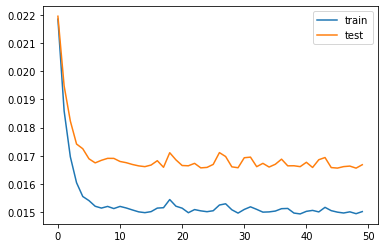

In [28]:
# graficamos la perdida
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [29]:
print(dataset_E162533_serie.index.min())
print(dataset_E162533_serie.index.max())

2018-07-17 00:00:00
2022-06-01 00:00:00


In [30]:
ultimos_meses = dataset_E162533_serie["2022-04-01":"2022-06-01"]
ultimos_meses

,valores
fecha_servicio,
2022-04-01,715
2022-04-02,840
2022-04-03,840
2022-04-04,715
2022-04-05,715
...,...
2022-05-28,715
2022-05-29,715
2022-05-30,715


In [31]:
ultimos_meses_values = ultimos_meses.values.astype("float32")
ultimos_meses_values

array([[7.150000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [7.150000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [7.150000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [7.1

In [32]:
ult_meses_values_reformado = ultimos_meses_values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
ult_meses_values_reformado

array([[7.150000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [7.150000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [7.150000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [7.150000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [8.400000e+02],
       [7.1

In [33]:
scaled = scaler.fit_transform(ult_meses_values_reformado)

In [34]:
scaler

MinMaxScaler()

In [35]:
um_supervised_df = series_to_supervised(scaled, 15, 1)
um_supervised_df.drop(um_supervised_df.columns[[15]], axis=1, inplace=True)
um_supervised_df

,var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
15,0.000000e+00,1.651183e-08,1.651183e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.651183e-08,1.651183e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.651183e-08,0.000000e+00,1.651183e-08,0.000000e+00
16,1.651183e-08,1.651183e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.651183e-08,1.651183e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.651183e-08,0.000000e+00,1.651183e-08,0.000000e+00,0.000000e+00
17,1.651183e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.651183e-08,1.651183e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.651183e-08,0.000000e+00,1.651183e-08,0.000000e+00,0.000000e+00,1.651183e-08
18,0.000000e+00,0.000000e+00,0.000000e+00,1.651183e-08,1.651183e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.651183e-08,0.000000e+00,1.651183e-08,0.000000e+00,0.000000e+00,1.651183e-08,1.651183e-08
19,0.000000e+00,0.000000e+00,1.651183e-08,1.651183e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.651183e-08,0.000000e+00,1.651183e-08,0.000000e+00,0.000000e+00,1.651183e-08,1.651183e-08,0.000000e+00
20,0.000000e+00,1.651183e-08,1.651183e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.651183e-08,0.000000e+00,1.651183e-08,0.000000e+00,0.000000e+00,1.651183e-08,1.651183e-08,0.000000e+00,1.651183e-08
21,1.651183e-08,1.651183e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.651183e-08,0.000000e+00,1.651183e-08,0.000000e+00,0.000000e+00,1.651183e-08,1.651183e-08,0.000000e+00,1.651183e-08,0.000000e+00
22,1.651183e-08,0.000000e+00,0.000000e+00,0.000000e+00,1.651183e-08,0.000000e+00,1.651183e-08,0.000000e+00,0.000000e+00,1.651183e-08,1.651183e-08,0.000000e+00,1.651183e-08,0.000000e+00,1.651183e-08
23,0.000000e+00,0.000000e+00,0.000000e+00,1.651183e-08,0.000000e+00,1.651183e-08,0.000000e+00,0.000000e+00,1.651183e-08,1.651183e-08,0.000000e+00,1.651183e-08,0.000000e+00,1.651183e-08,1.651183e-08
24,0.000000e+00,0.000000e+00,1.651183e-08,0.000000e+00,1.651183e-08,0.000000e+00,0.000000e+00,1.651183e-08,1.651183e-08,0.000000e+00,1.651183e-08,0.000000e+00,1.651183e-08,1.651183e-08,0.000000e+00


In [36]:
um_supervised_values = um_supervised_df.values
um_X_test = um_supervised_values[7:,:]
um_X_test

array([[1.6511834e-08, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.6511834e-08, 0.0000000e+00, 1.6511834e-08, 0.0000000e+00,
        0.0000000e+00, 1.6511834e-08, 1.6511834e-08, 0.0000000e+00,
        1.6511834e-08, 0.0000000e+00, 1.6511834e-08],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.6511834e-08,
        0.0000000e+00, 1.6511834e-08, 0.0000000e+00, 0.0000000e+00,
        1.6511834e-08, 1.6511834e-08, 0.0000000e+00, 1.6511834e-08,
        0.0000000e+00, 1.6511834e-08, 1.6511834e-08],
       [0.0000000e+00, 0.0000000e+00, 1.6511834e-08, 0.0000000e+00,
        1.6511834e-08, 0.0000000e+00, 0.0000000e+00, 1.6511834e-08,
        1.6511834e-08, 0.0000000e+00, 1.6511834e-08, 0.0000000e+00,
        1.6511834e-08, 1.6511834e-08, 0.0000000e+00],
       [0.0000000e+00, 1.6511834e-08, 0.0000000e+00, 1.6511834e-08,
        0.0000000e+00, 0.0000000e+00, 1.6511834e-08, 1.6511834e-08,
        0.0000000e+00, 1.6511834e-08, 0.0000000e+00, 1.6511834e-08,
        1.6511834e-08,

In [37]:
um_X_test.shape

(40, 15)

In [38]:
um_X_test_rsp = um_X_test.reshape((um_X_test.shape[0], 1, um_X_test.shape[1]))
um_X_test_rsp

array([[[1.6511834e-08, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         1.6511834e-08, 0.0000000e+00, 1.6511834e-08, 0.0000000e+00,
         0.0000000e+00, 1.6511834e-08, 1.6511834e-08, 0.0000000e+00,
         1.6511834e-08, 0.0000000e+00, 1.6511834e-08]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.6511834e-08,
         0.0000000e+00, 1.6511834e-08, 0.0000000e+00, 0.0000000e+00,
         1.6511834e-08, 1.6511834e-08, 0.0000000e+00, 1.6511834e-08,
         0.0000000e+00, 1.6511834e-08, 1.6511834e-08]],

       [[0.0000000e+00, 0.0000000e+00, 1.6511834e-08, 0.0000000e+00,
         1.6511834e-08, 0.0000000e+00, 0.0000000e+00, 1.6511834e-08,
         1.6511834e-08, 0.0000000e+00, 1.6511834e-08, 0.0000000e+00,
         1.6511834e-08, 1.6511834e-08, 0.0000000e+00]],

       [[0.0000000e+00, 1.6511834e-08, 0.0000000e+00, 1.6511834e-08,
         0.0000000e+00, 0.0000000e+00, 1.6511834e-08, 1.6511834e-08,
         0.0000000e+00, 1.6511834e-08, 0.0000000e+00, 1.6511834e-08,
 

In [39]:
um_X_test_rsp.shape

(40, 1, 15)

In [40]:
results=[]

for i in range(30):
    parcial=model.predict(um_X_test_rsp)
    results.append(parcial[0])
    print(um_X_test_rsp)
    x_test=agregarNuevoValor(um_X_test_rsp, parcial[0])

[[[1.6511834e-08 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.6511834e-08
   0.0000000e+00 1.6511834e-08 0.0000000e+00 0.0000000e+00 1.6511834e-08
   1.6511834e-08 0.0000000e+00 1.6511834e-08 0.0000000e+00 1.6511834e-08]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.6511834e-08 0.0000000e+00
   1.6511834e-08 0.0000000e+00 0.0000000e+00 1.6511834e-08 1.6511834e-08
   0.0000000e+00 1.6511834e-08 0.0000000e+00 1.6511834e-08 1.6511834e-08]]

 [[0.0000000e+00 0.0000000e+00 1.6511834e-08 0.0000000e+00 1.6511834e-08
   0.0000000e+00 0.0000000e+00 1.6511834e-08 1.6511834e-08 0.0000000e+00
   1.6511834e-08 0.0000000e+00 1.6511834e-08 1.6511834e-08 0.0000000e+00]]

 [[0.0000000e+00 1.6511834e-08 0.0000000e+00 1.6511834e-08 0.0000000e+00
   0.0000000e+00 1.6511834e-08 1.6511834e-08 0.0000000e+00 1.6511834e-08
   0.0000000e+00 1.6511834e-08 1.6511834e-08 0.0000000e+00 0.0000000e+00]]

 [[1.6511834e-08 0.0000000e+00 1.6511834e-08 0.0000000e+00 0.0000000e+00
   1.6511834e-08 1.6511834e-08 0.000000

[[[1.65118337e-08 0.00000000e+00 0.00000000e+00 1.65118337e-08
   1.65118337e-08 0.00000000e+00 1.65118337e-08 0.00000000e+00
   1.65118337e-08 1.06399035e-04 1.06524400e-04 1.06550549e-04
   1.06501626e-04 1.06480860e-04 1.06434411e-04]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.65118337e-08
   0.00000000e+00 1.65118337e-08 0.00000000e+00 0.00000000e+00
   1.65118337e-08 1.65118337e-08 0.00000000e+00 1.65118337e-08
   0.00000000e+00 1.65118337e-08 1.65118337e-08]]

 [[0.00000000e+00 0.00000000e+00 1.65118337e-08 0.00000000e+00
   1.65118337e-08 0.00000000e+00 0.00000000e+00 1.65118337e-08
   1.65118337e-08 0.00000000e+00 1.65118337e-08 0.00000000e+00
   1.65118337e-08 1.65118337e-08 0.00000000e+00]]

 [[0.00000000e+00 1.65118337e-08 0.00000000e+00 1.65118337e-08
   0.00000000e+00 0.00000000e+00 1.65118337e-08 1.65118337e-08
   0.00000000e+00 1.65118337e-08 0.00000000e+00 1.65118337e-08
   1.65118337e-08 0.00000000e+00 0.00000000e+00]]

 [[1.65118337e-08 0.00000000e+00 1.65118

[[[1.65118337e-08 0.00000000e+00 1.65118337e-08 1.06399035e-04
   1.06524400e-04 1.06550549e-04 1.06501626e-04 1.06480860e-04
   1.06434411e-04 1.06300766e-04 1.06207197e-04 1.06257343e-04
   1.06368971e-04 1.06351043e-04 1.06263236e-04]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.65118337e-08
   0.00000000e+00 1.65118337e-08 0.00000000e+00 0.00000000e+00
   1.65118337e-08 1.65118337e-08 0.00000000e+00 1.65118337e-08
   0.00000000e+00 1.65118337e-08 1.65118337e-08]]

 [[0.00000000e+00 0.00000000e+00 1.65118337e-08 0.00000000e+00
   1.65118337e-08 0.00000000e+00 0.00000000e+00 1.65118337e-08
   1.65118337e-08 0.00000000e+00 1.65118337e-08 0.00000000e+00
   1.65118337e-08 1.65118337e-08 0.00000000e+00]]

 [[0.00000000e+00 1.65118337e-08 0.00000000e+00 1.65118337e-08
   0.00000000e+00 0.00000000e+00 1.65118337e-08 1.65118337e-08
   0.00000000e+00 1.65118337e-08 0.00000000e+00 1.65118337e-08
   1.65118337e-08 0.00000000e+00 0.00000000e+00]]

 [[1.65118337e-08 0.00000000e+00 1.65118

[[[1.06550549e-04 1.06501626e-04 1.06480860e-04 1.06434411e-04
   1.06300766e-04 1.06207197e-04 1.06257343e-04 1.06368971e-04
   1.06351043e-04 1.06263236e-04 1.06347987e-04 1.06298248e-04
   1.06310588e-04 1.06394713e-04 1.06394873e-04]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.65118337e-08
   0.00000000e+00 1.65118337e-08 0.00000000e+00 0.00000000e+00
   1.65118337e-08 1.65118337e-08 0.00000000e+00 1.65118337e-08
   0.00000000e+00 1.65118337e-08 1.65118337e-08]]

 [[0.00000000e+00 0.00000000e+00 1.65118337e-08 0.00000000e+00
   1.65118337e-08 0.00000000e+00 0.00000000e+00 1.65118337e-08
   1.65118337e-08 0.00000000e+00 1.65118337e-08 0.00000000e+00
   1.65118337e-08 1.65118337e-08 0.00000000e+00]]

 [[0.00000000e+00 1.65118337e-08 0.00000000e+00 1.65118337e-08
   0.00000000e+00 0.00000000e+00 1.65118337e-08 1.65118337e-08
   0.00000000e+00 1.65118337e-08 0.00000000e+00 1.65118337e-08
   1.65118337e-08 0.00000000e+00 0.00000000e+00]]

 [[1.65118337e-08 0.00000000e+00 1.65118

[[[1.06207197e-04 1.06257343e-04 1.06368971e-04 1.06351043e-04
   1.06263236e-04 1.06347987e-04 1.06298248e-04 1.06310588e-04
   1.06394713e-04 1.06394873e-04 1.06395222e-04 1.06395208e-04
   1.06395019e-04 1.06394902e-04 1.06394844e-04]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.65118337e-08
   0.00000000e+00 1.65118337e-08 0.00000000e+00 0.00000000e+00
   1.65118337e-08 1.65118337e-08 0.00000000e+00 1.65118337e-08
   0.00000000e+00 1.65118337e-08 1.65118337e-08]]

 [[0.00000000e+00 0.00000000e+00 1.65118337e-08 0.00000000e+00
   1.65118337e-08 0.00000000e+00 0.00000000e+00 1.65118337e-08
   1.65118337e-08 0.00000000e+00 1.65118337e-08 0.00000000e+00
   1.65118337e-08 1.65118337e-08 0.00000000e+00]]

 [[0.00000000e+00 1.65118337e-08 0.00000000e+00 1.65118337e-08
   0.00000000e+00 0.00000000e+00 1.65118337e-08 1.65118337e-08
   0.00000000e+00 1.65118337e-08 0.00000000e+00 1.65118337e-08
   1.65118337e-08 0.00000000e+00 0.00000000e+00]]

 [[1.65118337e-08 0.00000000e+00 1.65118

[[[1.06347987e-04 1.06298248e-04 1.06310588e-04 1.06394713e-04
   1.06394873e-04 1.06395222e-04 1.06395208e-04 1.06395019e-04
   1.06394902e-04 1.06394844e-04 1.06394640e-04 1.06394626e-04
   1.06394931e-04 1.06394815e-04 1.06394713e-04]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.65118337e-08
   0.00000000e+00 1.65118337e-08 0.00000000e+00 0.00000000e+00
   1.65118337e-08 1.65118337e-08 0.00000000e+00 1.65118337e-08
   0.00000000e+00 1.65118337e-08 1.65118337e-08]]

 [[0.00000000e+00 0.00000000e+00 1.65118337e-08 0.00000000e+00
   1.65118337e-08 0.00000000e+00 0.00000000e+00 1.65118337e-08
   1.65118337e-08 0.00000000e+00 1.65118337e-08 0.00000000e+00
   1.65118337e-08 1.65118337e-08 0.00000000e+00]]

 [[0.00000000e+00 1.65118337e-08 0.00000000e+00 1.65118337e-08
   0.00000000e+00 0.00000000e+00 1.65118337e-08 1.65118337e-08
   0.00000000e+00 1.65118337e-08 0.00000000e+00 1.65118337e-08
   1.65118337e-08 0.00000000e+00 0.00000000e+00]]

 [[1.65118337e-08 0.00000000e+00 1.65118

In [41]:
adimen = [x for x in results]
adimen

[array([0.0001064], dtype=float32),
 array([0.00010652], dtype=float32),
 array([0.00010655], dtype=float32),
 array([0.0001065], dtype=float32),
 array([0.00010648], dtype=float32),
 array([0.00010643], dtype=float32),
 array([0.0001063], dtype=float32),
 array([0.00010621], dtype=float32),
 array([0.00010626], dtype=float32),
 array([0.00010637], dtype=float32),
 array([0.00010635], dtype=float32),
 array([0.00010626], dtype=float32),
 array([0.00010635], dtype=float32),
 array([0.0001063], dtype=float32),
 array([0.00010631], dtype=float32),
 array([0.00010639], dtype=float32),
 array([0.00010639], dtype=float32),
 array([0.0001064], dtype=float32),
 array([0.0001064], dtype=float32),
 array([0.0001064], dtype=float32),
 array([0.00010639], dtype=float32),
 array([0.00010639], dtype=float32),
 array([0.00010639], dtype=float32),
 array([0.00010639], dtype=float32),
 array([0.00010639], dtype=float32),
 array([0.00010639], dtype=float32),
 array([0.00010639], dtype=float32),
 array([

In [42]:
adimen_inverted = scaler.inverse_transform(adimen)
adimen_inverted

array([[806190.61854105],
       [807139.67084635],
       [807337.63335275],
       [806967.26610372],
       [806810.06382401],
       [806458.4242467 ],
       [805446.68932252],
       [804738.34268026],
       [805117.96360238],
       [805963.02224822],
       [805827.30170961],
       [805162.57952619],
       [805804.16752689],
       [805427.63116247],
       [805521.04919554],
       [806157.90019692],
       [806159.11198745],
       [806161.75589404],
       [806161.64573127],
       [806160.2136152 ],
       [806159.332313  ],
       [806158.8916619 ],
       [806157.34938305],
       [806157.23922027],
       [806159.55263855],
       [806158.67133635],
       [806157.90019692],
       [806158.8916619 ],
       [806158.34084802],
       [806158.4510108 ]])

<AxesSubplot:>

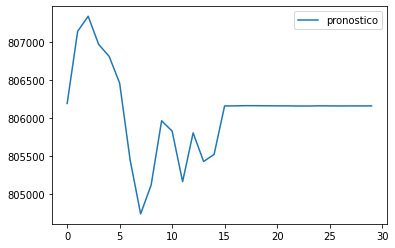

In [43]:
prediccionSig15dias = pd.DataFrame(adimen_inverted)
prediccionSig15dias.columns = ['pronostico']
prediccionSig15dias.plot()

In [44]:
orden_original = ["tubo_rayosx", "tarjeta_detector", "tarjeta_IOB", 
                  "otras_tarjetas", "motor","software","PILZ",
                  "shutter","cables","otro","uso_intensivo",
                  "picos_electricos","temp_planta","mtto_planta",
                  "mtto_correctivo"]

In [45]:
def df_serie_a_original(prediccion):
    columnas_actualizadas = []
#     columnas_actualizadas.append(orden_original)
    for pred in prediccion:
        
        pred_list = list(str(dec_to_base(pred[0], 5)))
        
        while len(pred_list) != len(orden_original):
            pred_list.insert(0, 0)
        
        columnas_actualizadas.append(pred_list)
        
    nuevo_df = pd.DataFrame(array(columnas_actualizadas), columns=orden_original)
    return nuevo_df

In [46]:
df_serie_a_original(adimen_inverted).to_csv("pronostico.csv")
df_serie_a_original(adimen_inverted)

,tubo_rayosx,tarjeta_detector,tarjeta_IOB,otras_tarjetas,motor,software,PILZ,shutter,cables,otro,uso_intensivo,picos_electricos,temp_planta,mtto_planta,mtto_correctivo
0,0,0,0,0,0,0,2,0,1,2,4,4,2,3,0
1,0,0,0,0,0,0,2,0,1,3,1,2,0,2,4
2,0,0,0,0,0,0,2,0,1,3,1,3,3,2,2
3,0,0,0,0,0,0,2,0,1,3,1,0,3,3,2
4,0,0,0,0,0,0,2,0,1,3,0,4,2,2,0
5,0,0,0,0,0,0,2,0,1,3,0,1,3,1,3
6,0,0,0,0,0,0,2,0,1,2,3,3,2,4,1
7,0,0,0,0,0,0,2,0,1,2,2,2,4,2,3
8,0,0,0,0,0,0,2,0,1,2,3,0,4,3,2
9,0,0,0,0,0,0,2,0,1,2,4,2,3,2,3
